In [1]:
import pandas as pd
import numpy as np
import os
import sys
from datetime import datetime


sys.path.append(r"C:\WorkNote\datadogCorr")
sys.path.append(r"C:\WorkNote\DL")

from PerformanceCounter import *
from functions import *
from StationaryTest import *
from math_functions import *
from transferEntropy import *
from CorrelationAnalysis import *
from CausalityInference import *
from neuralNetwork import *

import warnings       
warnings.filterwarnings ("ignore")

#### selected: prosessor time

In [2]:
sp_list = ['Users logged in','Total query execution time','Total data query executions',
'Queries being executed','Queries open','Lock wait time (ms/sec)','DataChange submit rate','% Processor Time']
pc_list_num = 0
proce_time = PC(pc_list_num,sp_list)

In [3]:
dct = proce_time.sp_dct
mc_list = proce_time.machine_list
sp_var = proce_time.sp_variables
sp = sp_var[0]

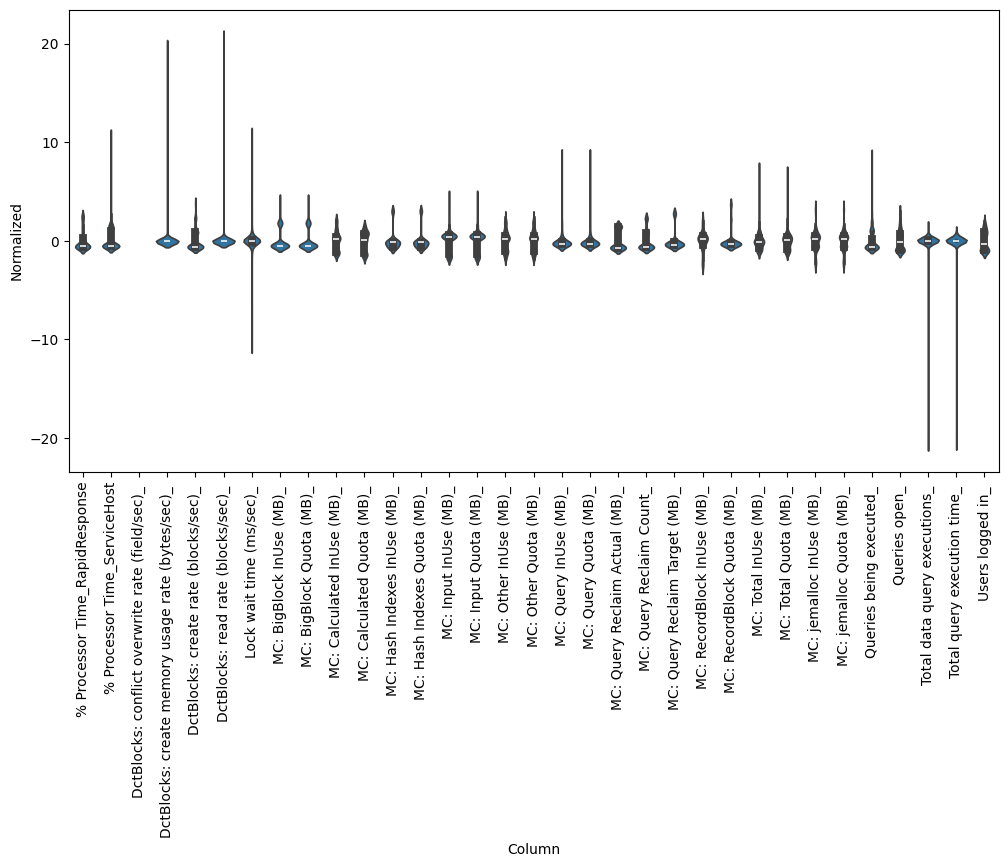

In [4]:
# already select the machine num here 
# the first machine does not have the processor time metrics, all 0
machine_list_num = 1
scaler = RobustScaler()
df,df_dct = display_df_pc(dct, mc_list, machine_list_num ,sp_var)

### stationary test
在此处就可以做简单的关联性分析
对于几个非平稳的时间序列，如果由他们组成的线性组合变量，是平稳的序列，就可以认定这几个变量存在协整关系，经济意义可以解释为这几个变量间具有长期均衡关系

In [5]:
# remove all 0 col
df = df.loc[:, (df != 0).any(axis=0)]
coin_liz, coin_dct = en_gr_test(df)

The coingeration variables are:  Index(['% Processor Time_ServiceHost',
       'DctBlocks: create memory usage rate (bytes/sec)_ ',
       'DctBlocks: create rate (blocks/sec)_ ',
       'DctBlocks: read rate (blocks/sec)_ ', 'Lock wait time (ms/sec)_ ',
       'MC: BigBlock InUse (MB)_ ', 'MC: BigBlock Quota (MB)_ ',
       'MC: Query Reclaim Actual (MB)_ ', 'MC: Query Reclaim Count_ ',
       'MC: Query Reclaim Target (MB)_ ', 'Queries being executed_ ',
       'Total data query executions_ ', 'Total query execution time_ ',
       'Users logged in_ '],
      dtype='object')


<Figure size 640x480 with 0 Axes>

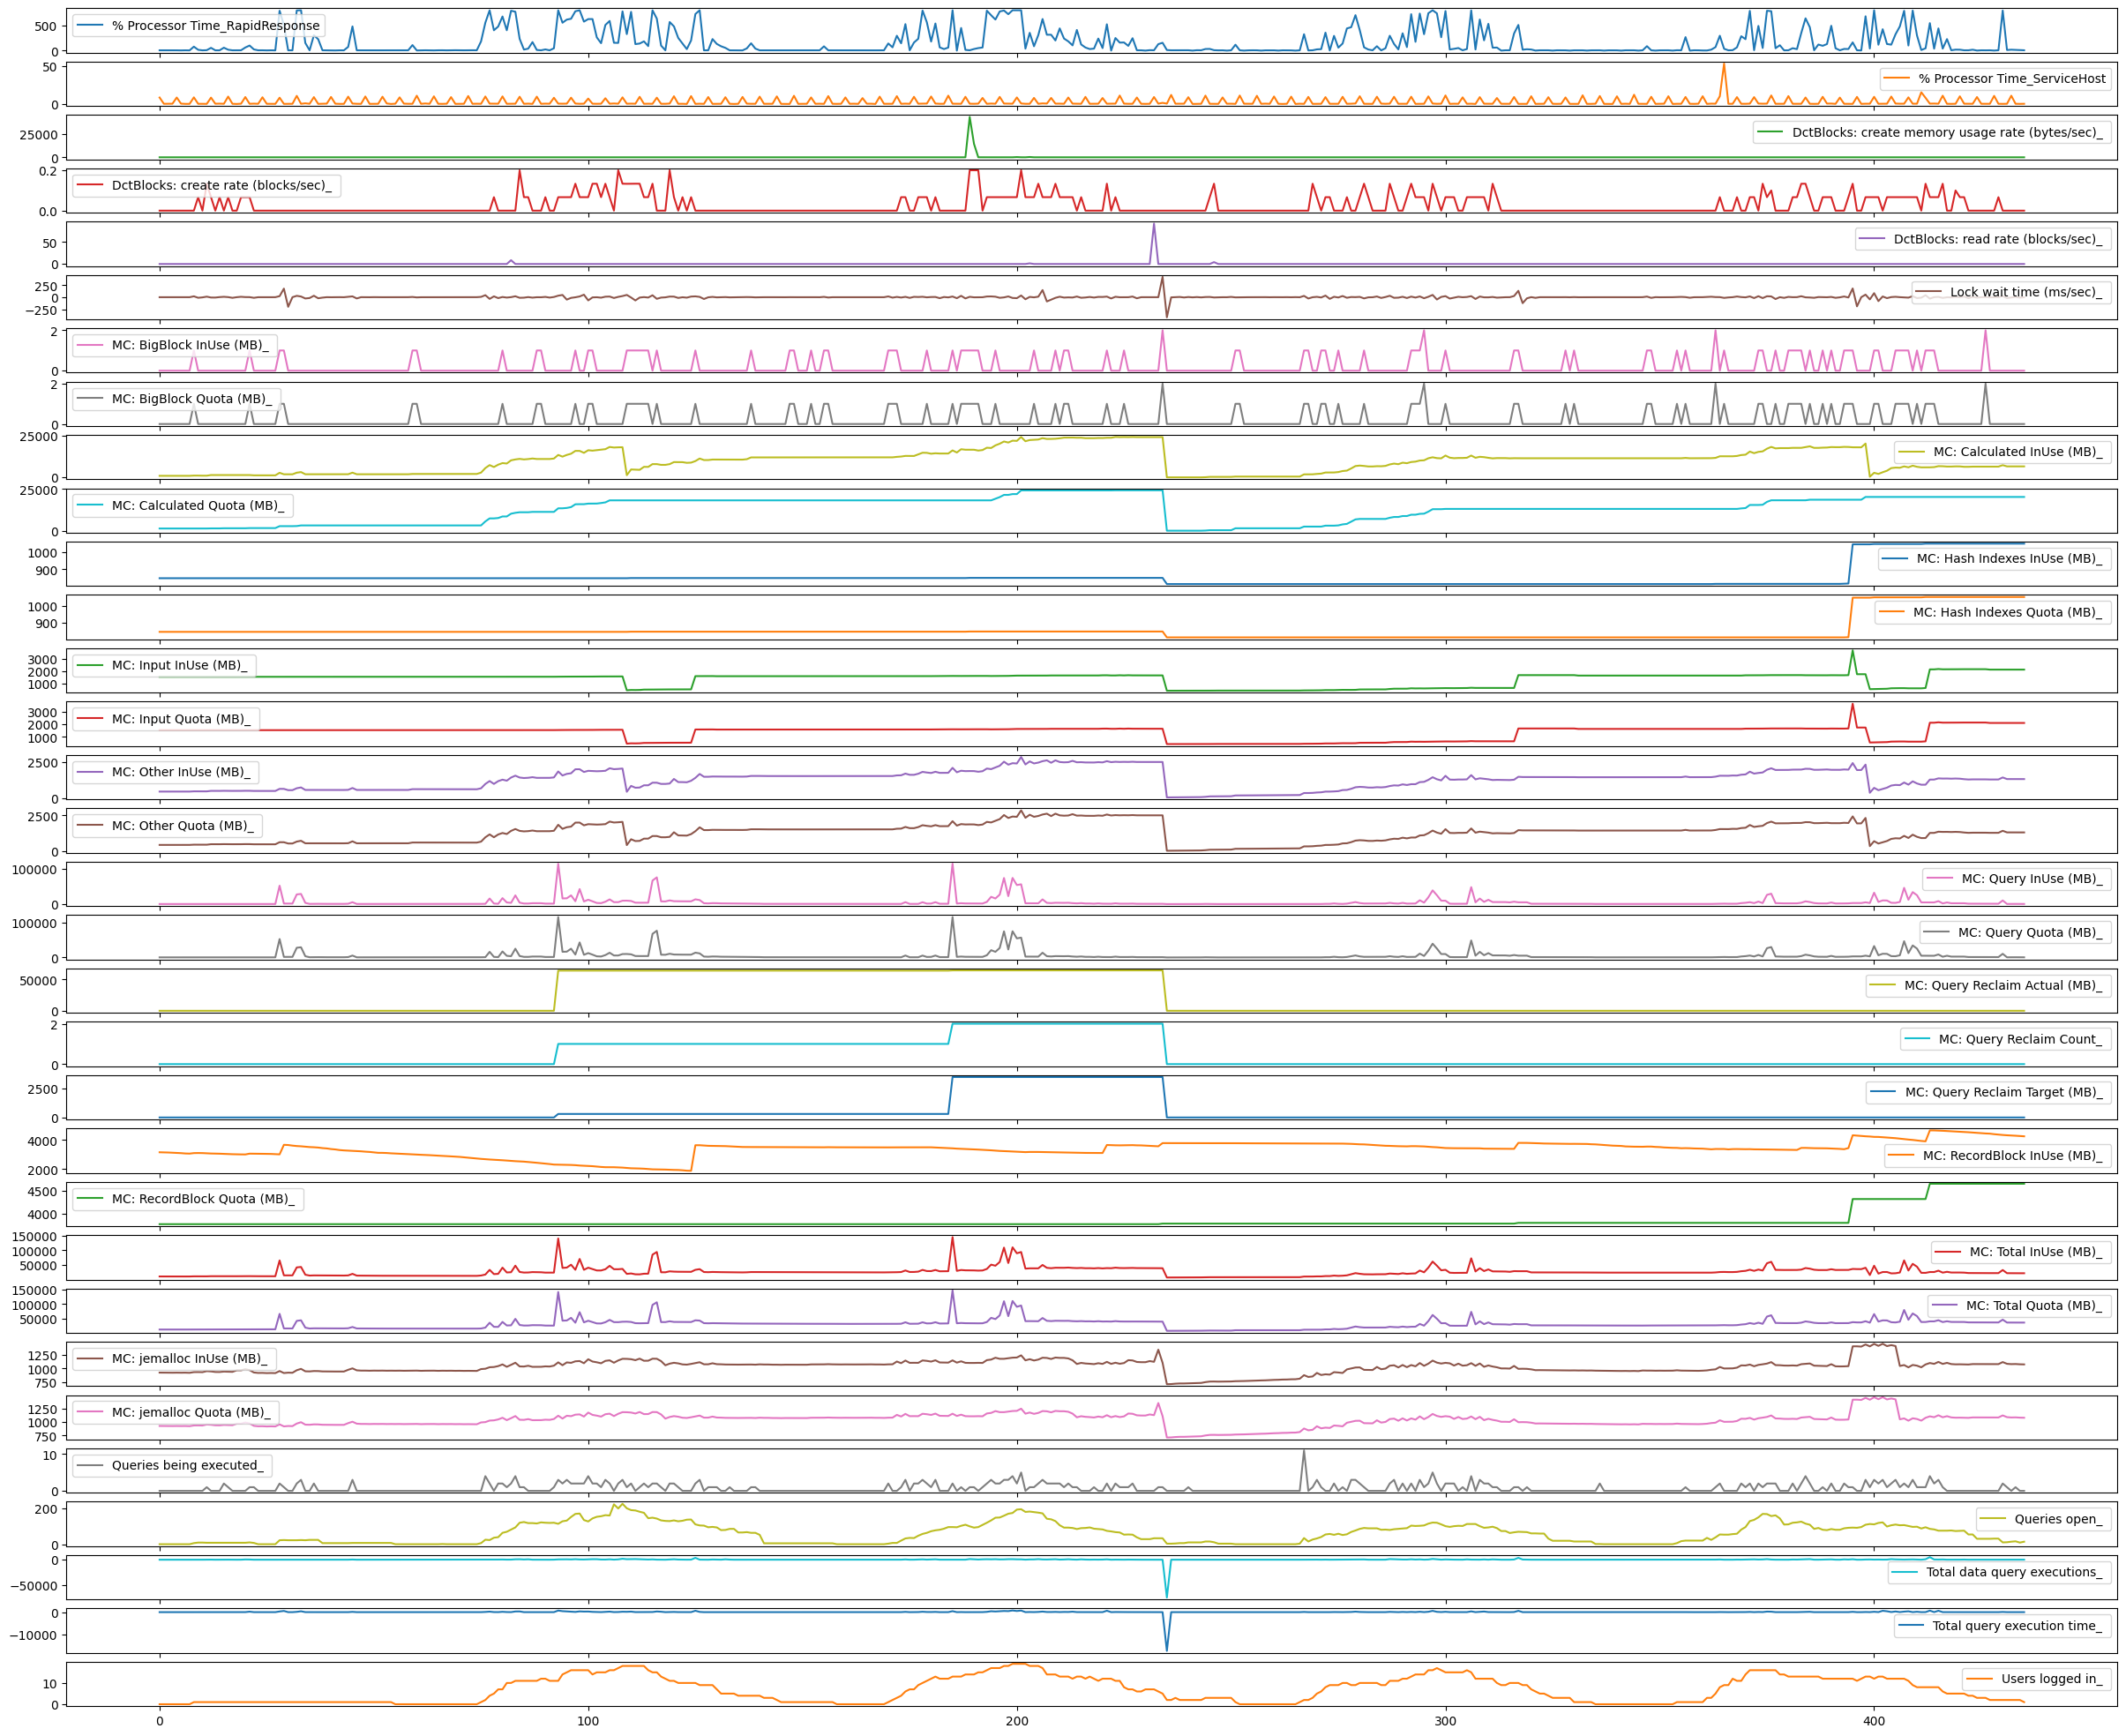

In [6]:
# visualize the unstationary data
fig = plt.figure( )
df.plot(subplots=True,figsize=(30,25))
plt.show()

<Figure size 640x480 with 0 Axes>

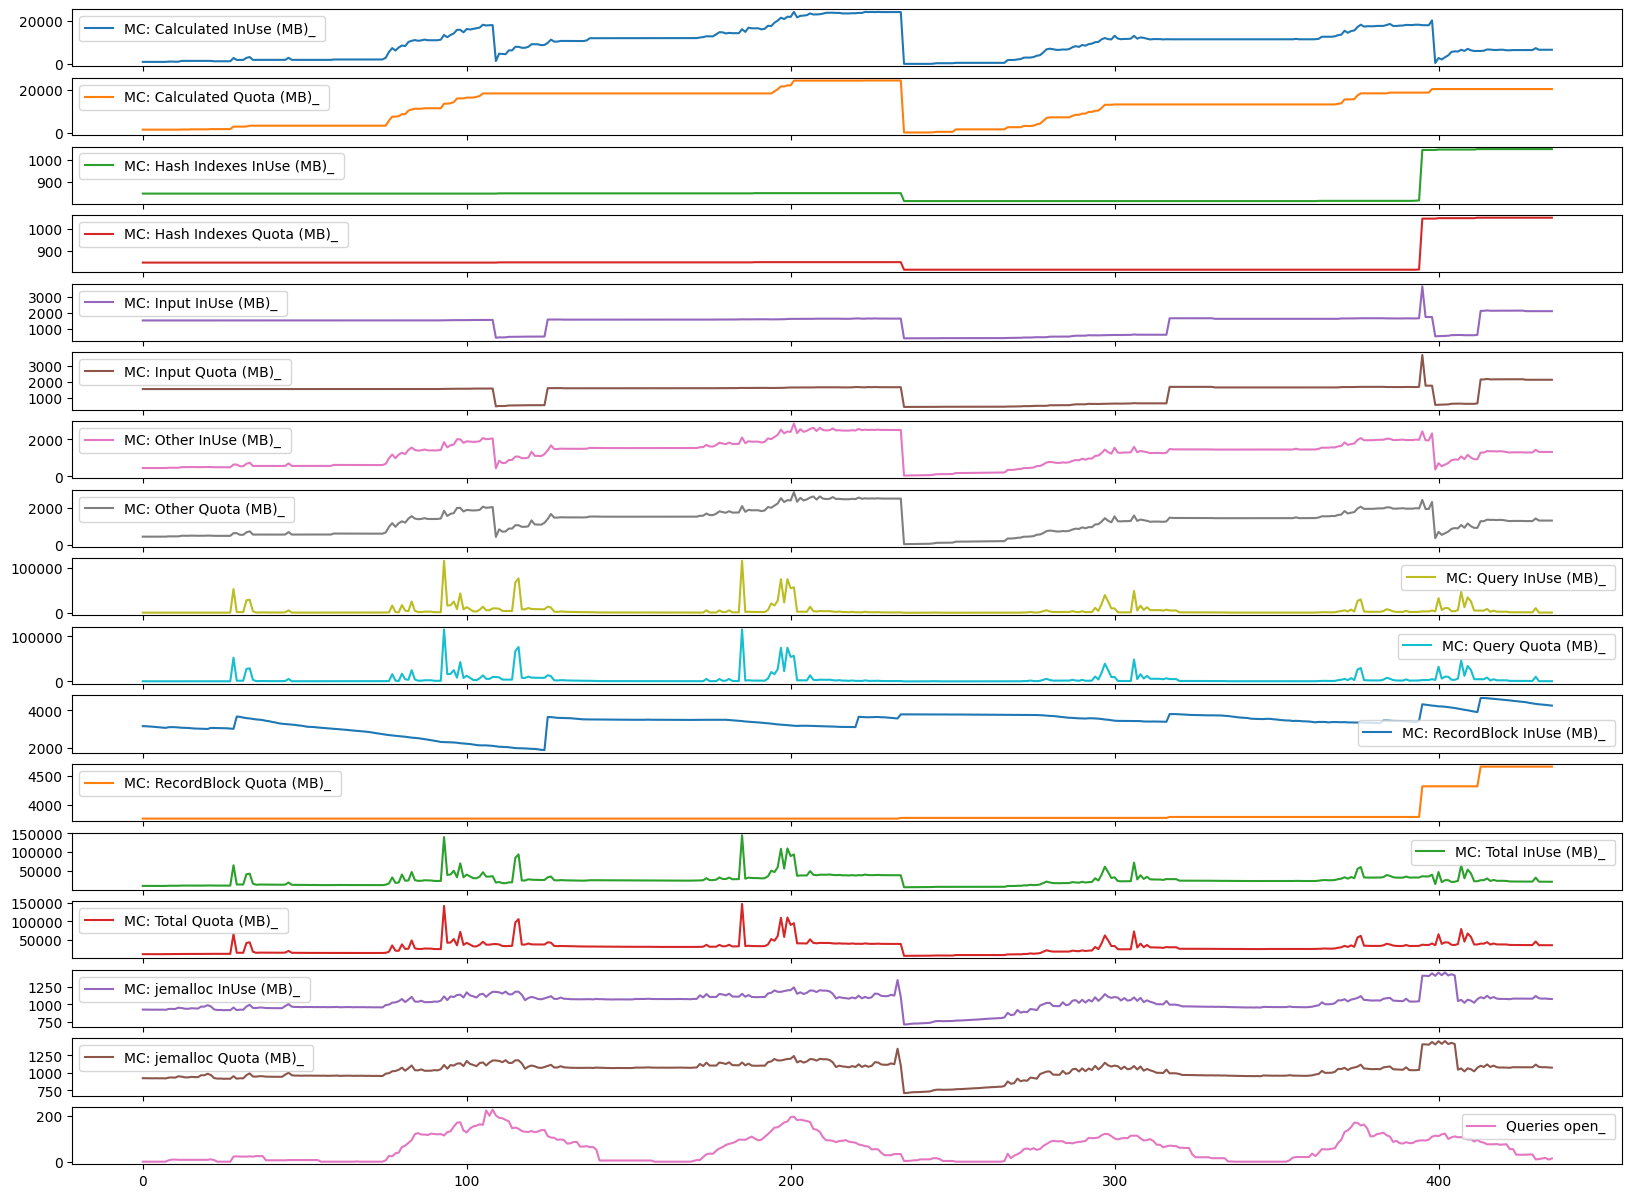

In [7]:
# visualize the unstationary data
uncoin_df = df.drop(columns = df.columns[coin_liz])
uncoin_df = uncoin_df.drop(columns = ['% Processor Time_RapidResponse'])
fig = plt.figure( )
uncoin_df.plot(subplots=True,figsize=(20,15))
plt.legend(loc='upper right')
plt.show()

In [8]:
diff = uncoin_df.diff(4).dropna()
station_test(diff.columns,diff)

ADF Test of: MC: Calculated InUse (MB)_ 
MC: Calculated InUse (MB)_  is stationary
KPSS Test of: MC: Calculated InUse (MB)_ 
MC: Calculated InUse (MB)_  is stationary
ADF Test of: MC: Calculated Quota (MB)_ 
MC: Calculated Quota (MB)_  is stationary
KPSS Test of: MC: Calculated Quota (MB)_ 
MC: Calculated Quota (MB)_  is stationary
ADF Test of: MC: Hash Indexes InUse (MB)_ 
MC: Hash Indexes InUse (MB)_  is stationary
KPSS Test of: MC: Hash Indexes InUse (MB)_ 
MC: Hash Indexes InUse (MB)_  is stationary
ADF Test of: MC: Hash Indexes Quota (MB)_ 
MC: Hash Indexes Quota (MB)_  is stationary
KPSS Test of: MC: Hash Indexes Quota (MB)_ 
MC: Hash Indexes Quota (MB)_  is stationary
ADF Test of: MC: Input InUse (MB)_ 
MC: Input InUse (MB)_  is stationary
KPSS Test of: MC: Input InUse (MB)_ 
MC: Input InUse (MB)_  is stationary
ADF Test of: MC: Input Quota (MB)_ 
MC: Input Quota (MB)_  is stationary
KPSS Test of: MC: Input Quota (MB)_ 
MC: Input Quota (MB)_  is stationary
ADF Test of: MC: Other

In [9]:
#df[df.columns[coin_liz]]
mod_df = pd.concat([df['% Processor Time_RapidResponse'],df[df.columns[coin_liz]]],axis = 1)
mod_df = pd.concat([mod_df,diff],axis = 1)
mod_df.fillna(0, inplace=True)

### Correlation analysis

 Computing feature importance...


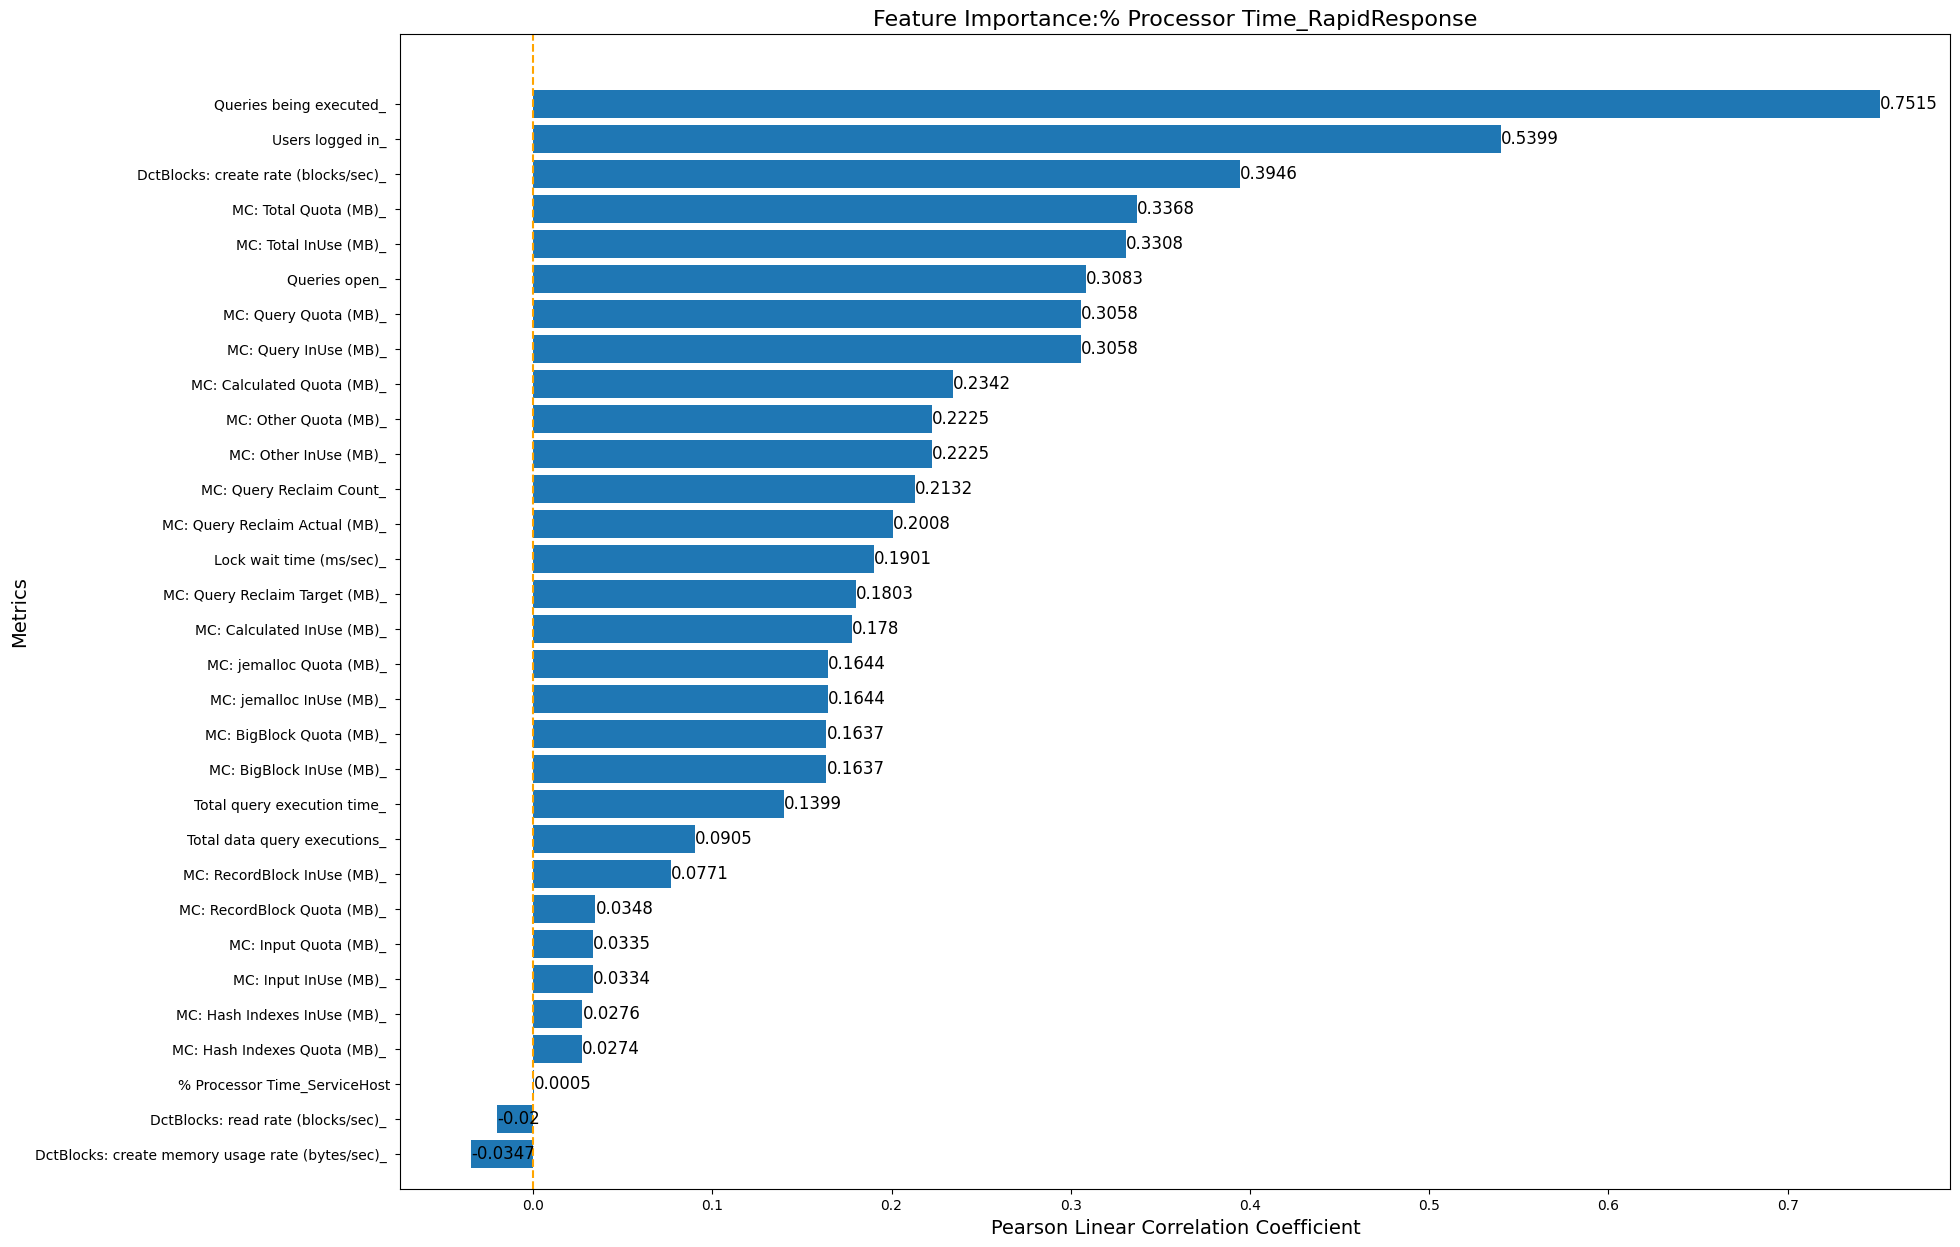

In [10]:
pearson_coe_dct = pearson_corr_test(mod_df)

 Computing feature importance...


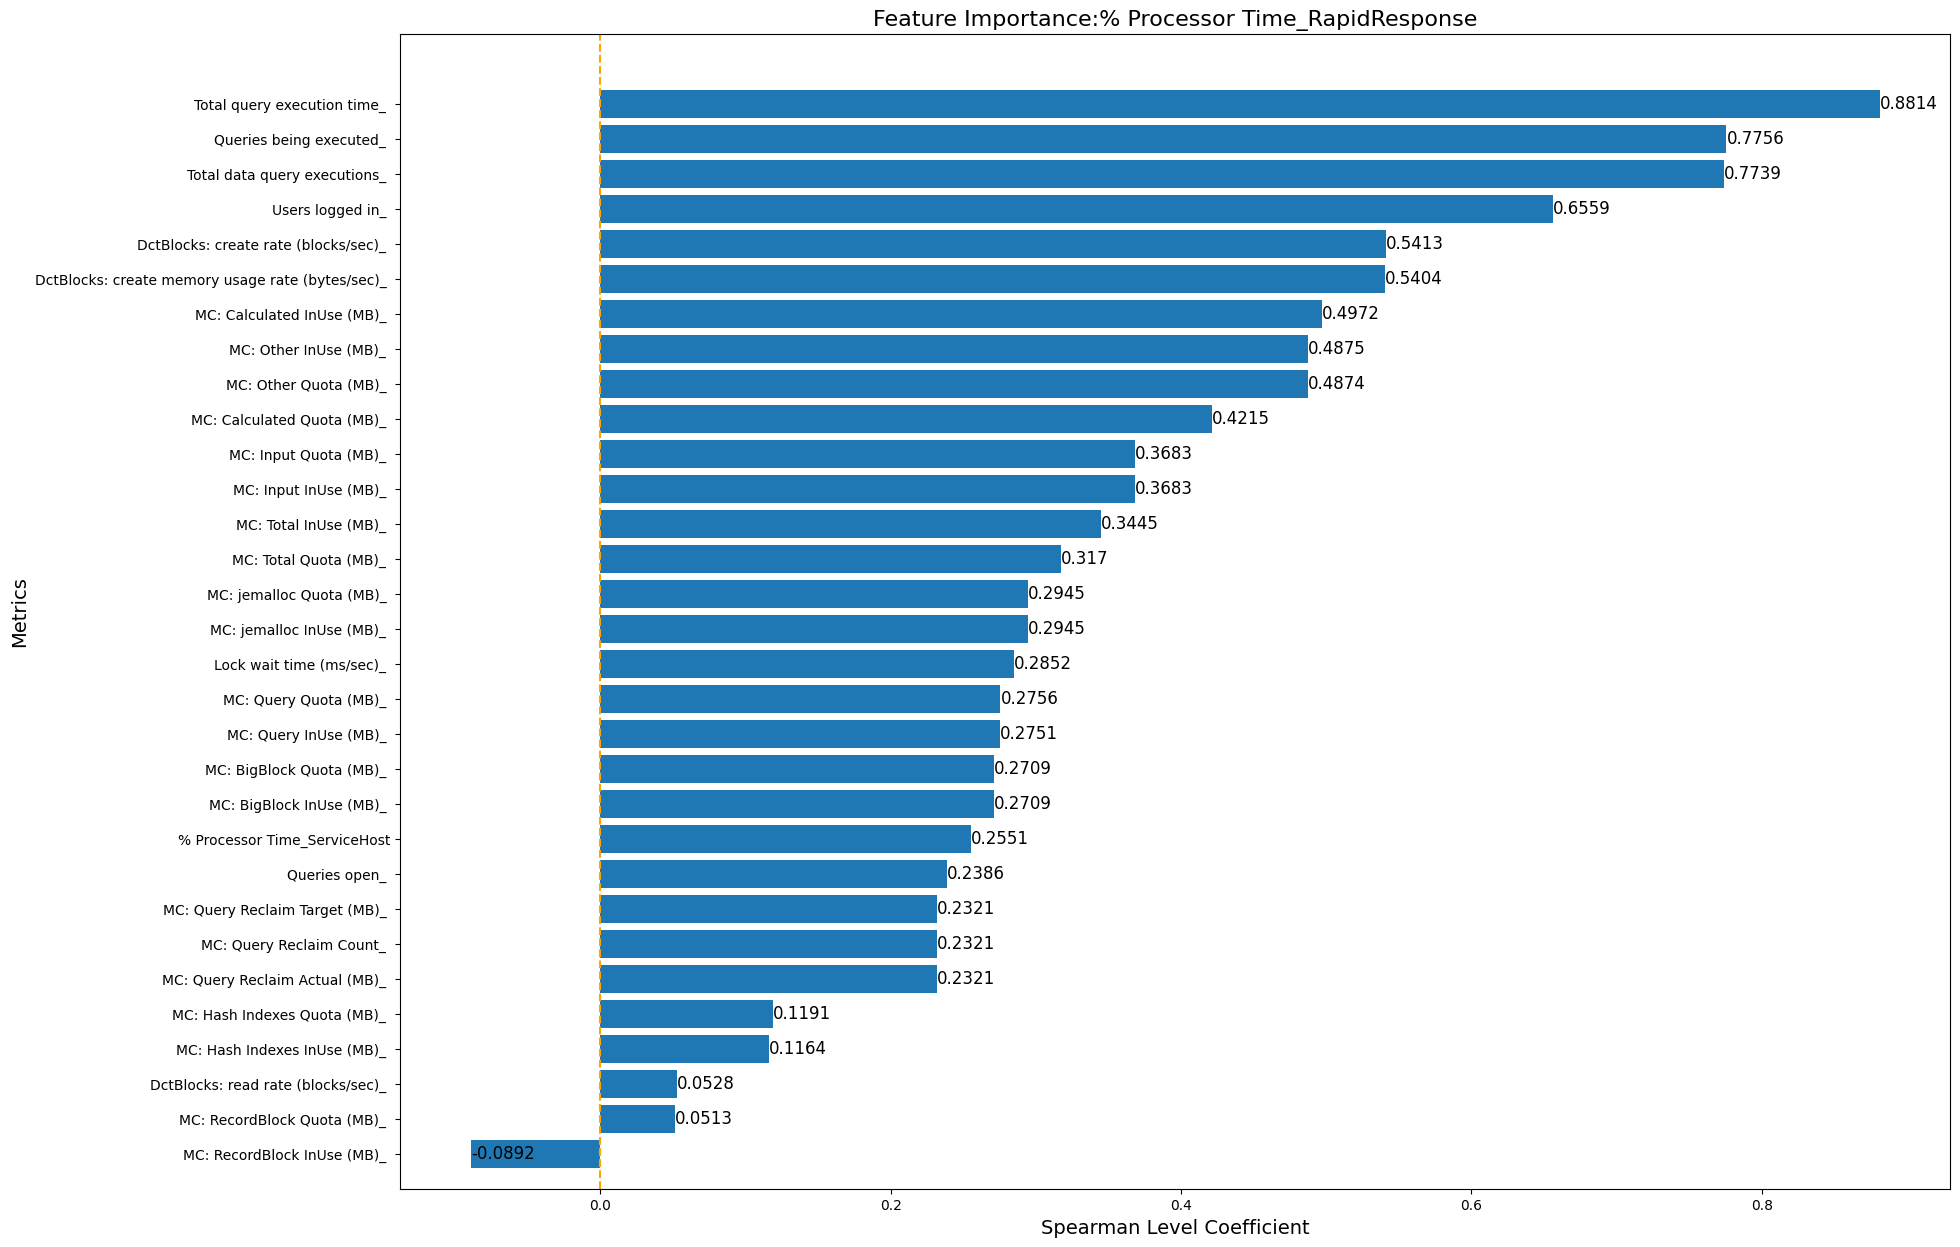

 Computing feature importance...


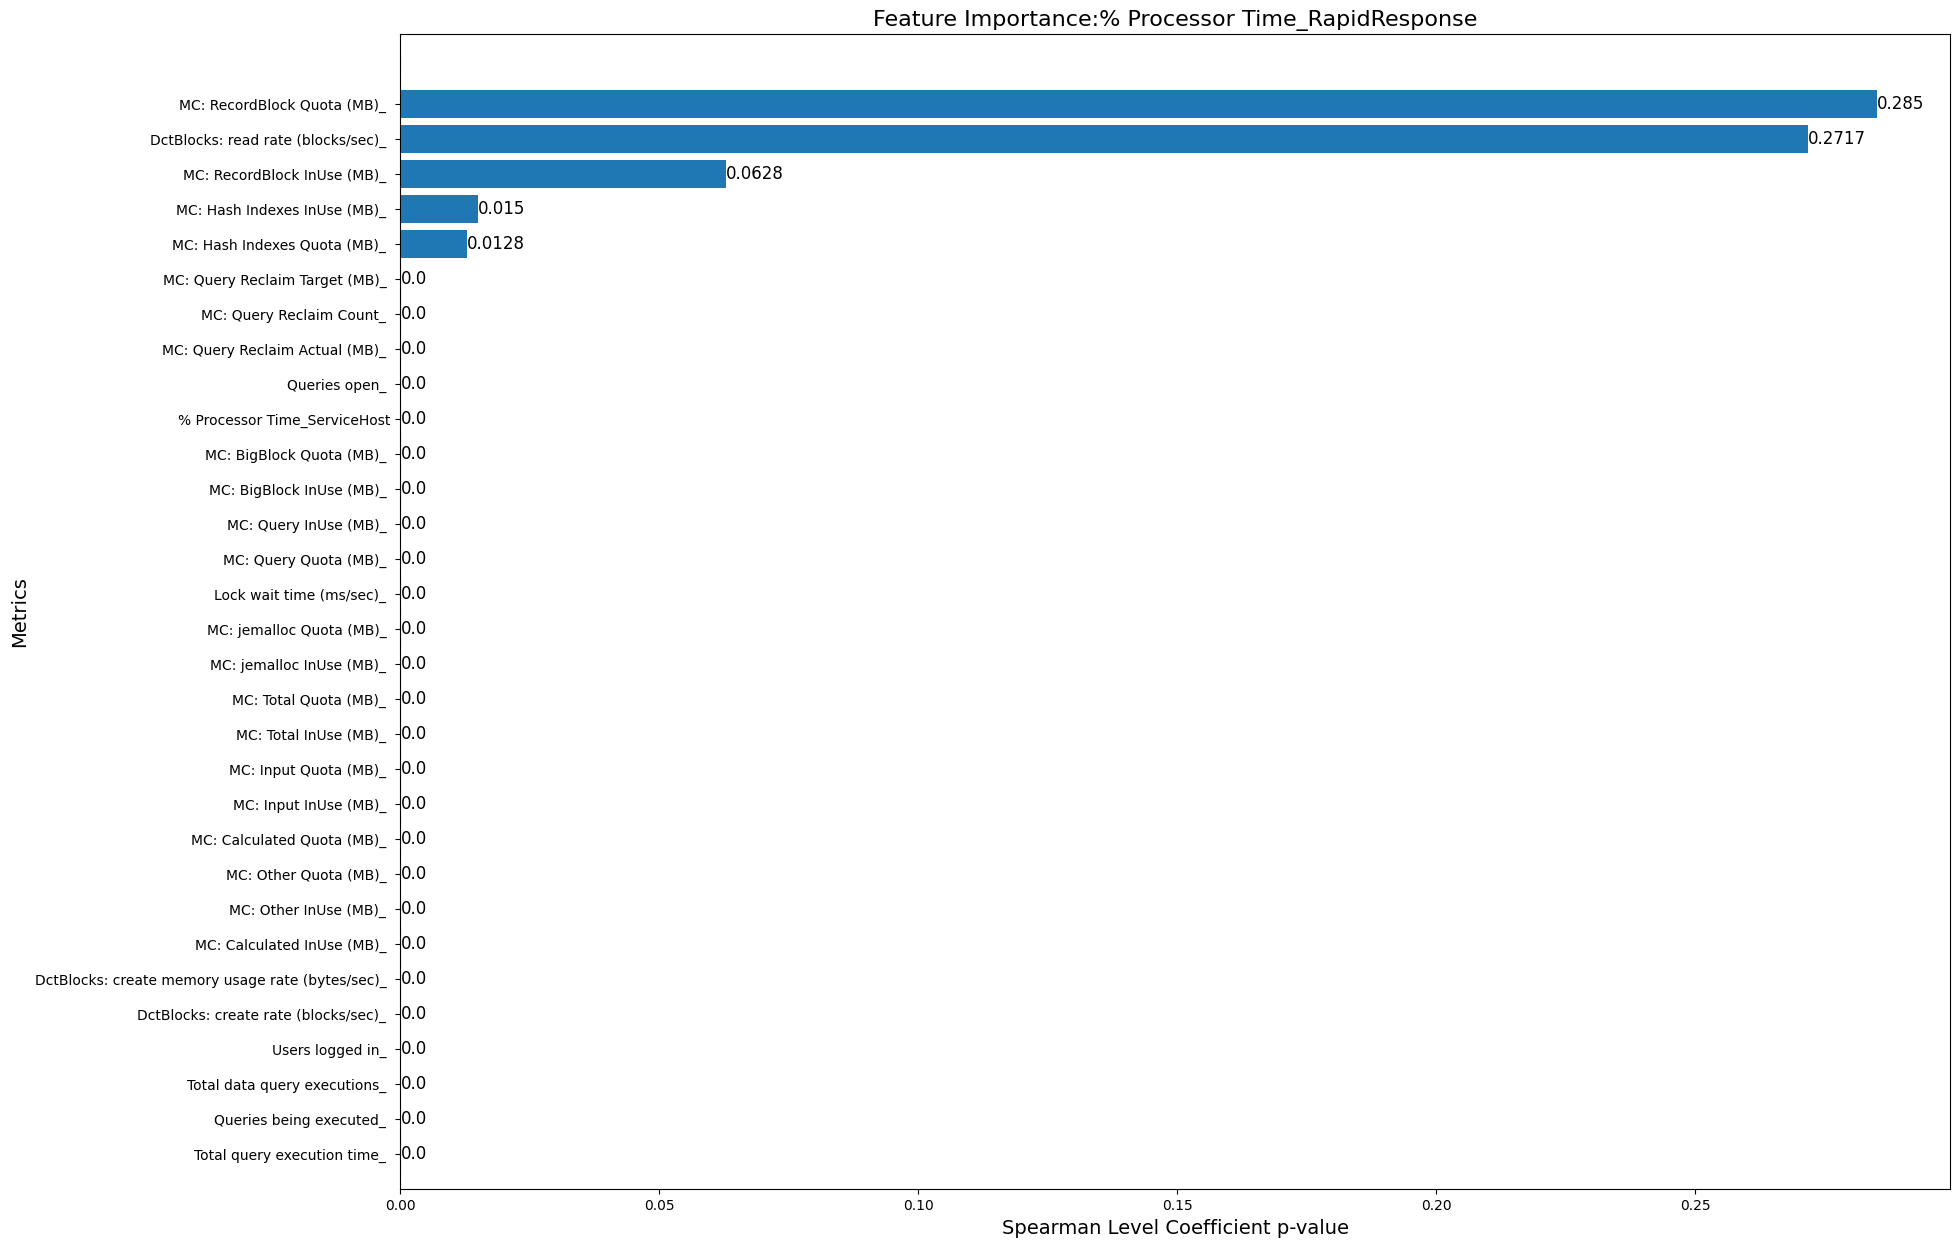

In [11]:
spear_coe_dct = spearman_corr_test(mod_df)

 Computing feature importance...


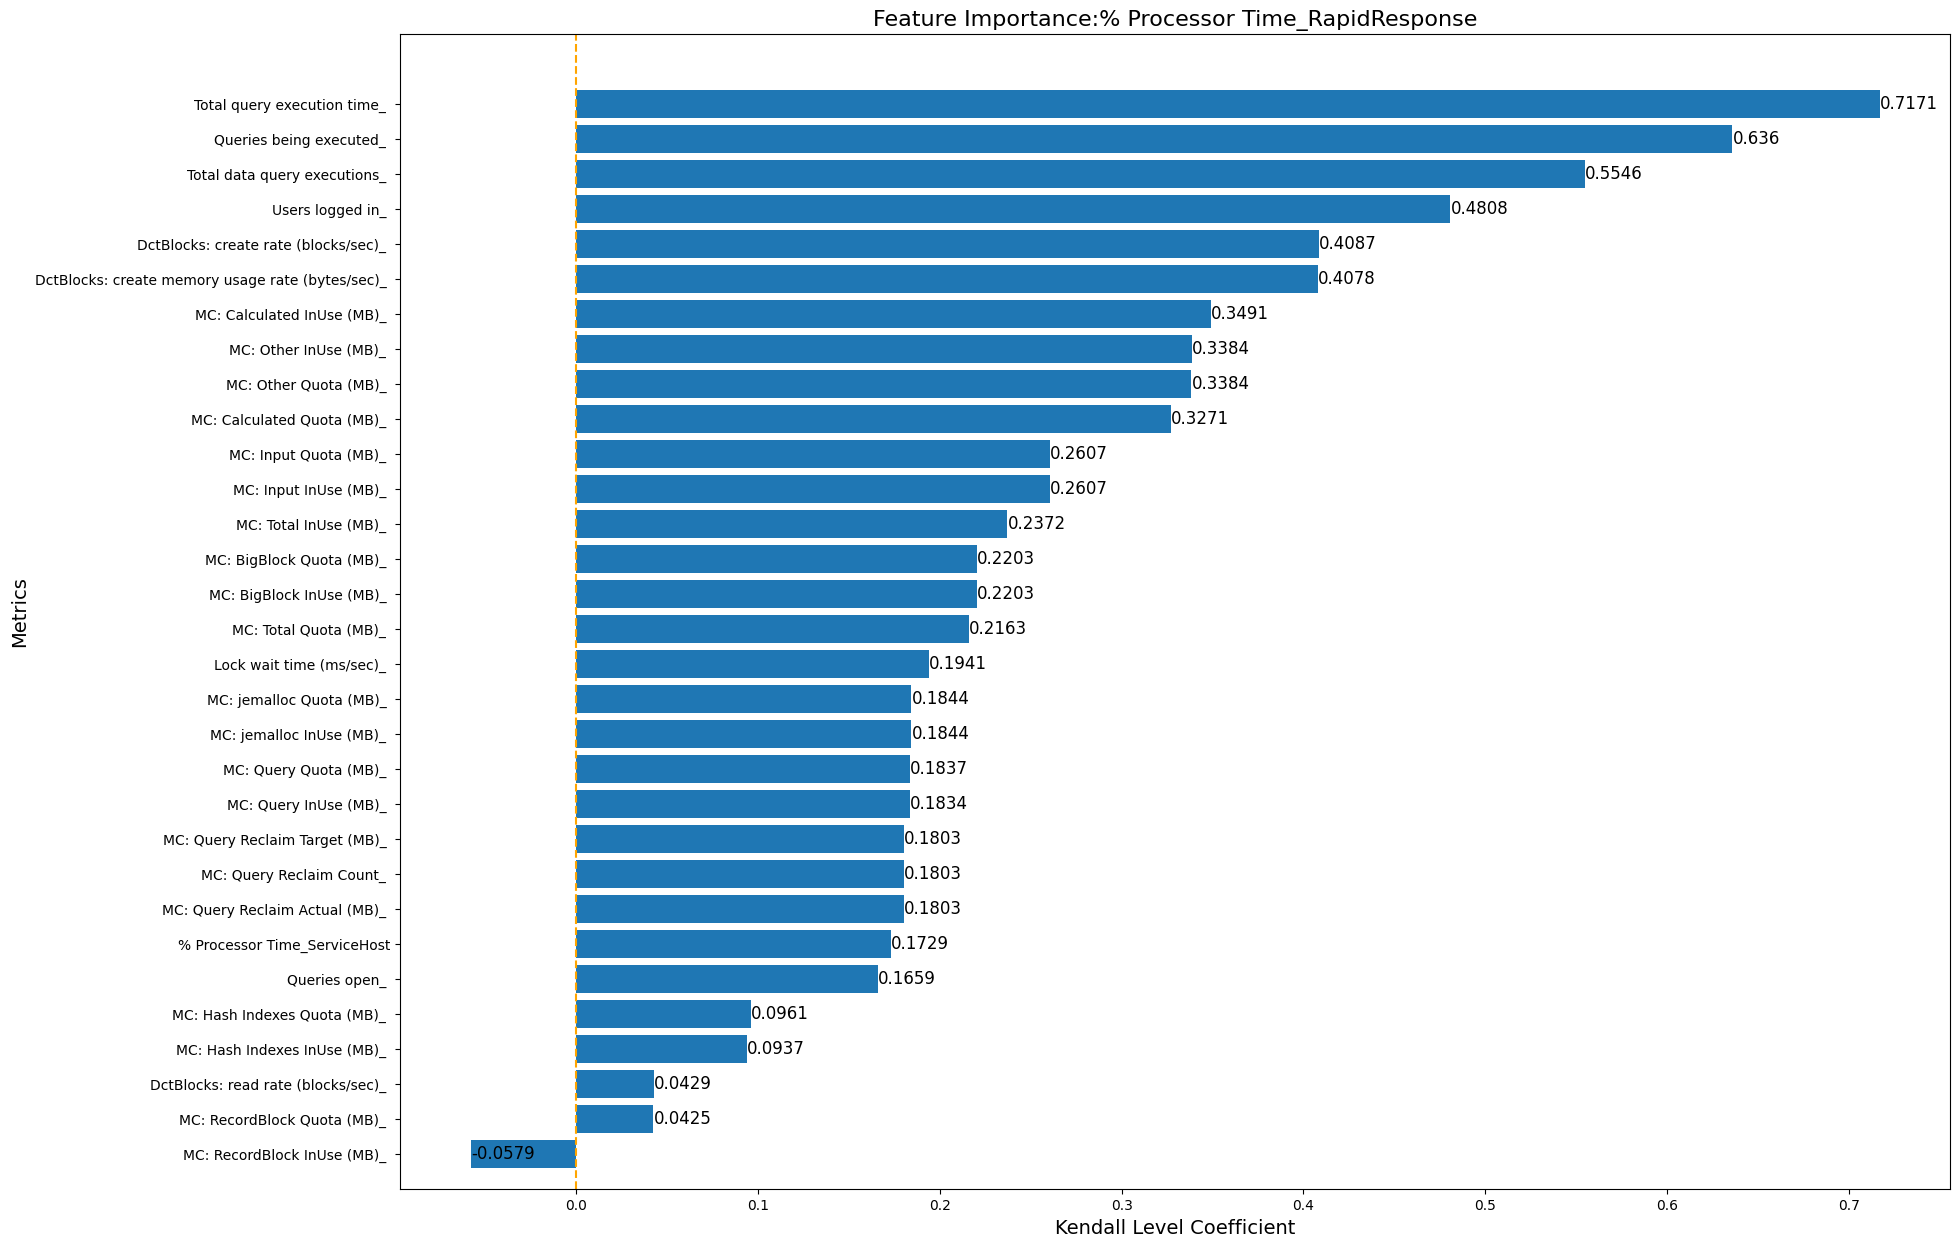

 Computing feature importance...


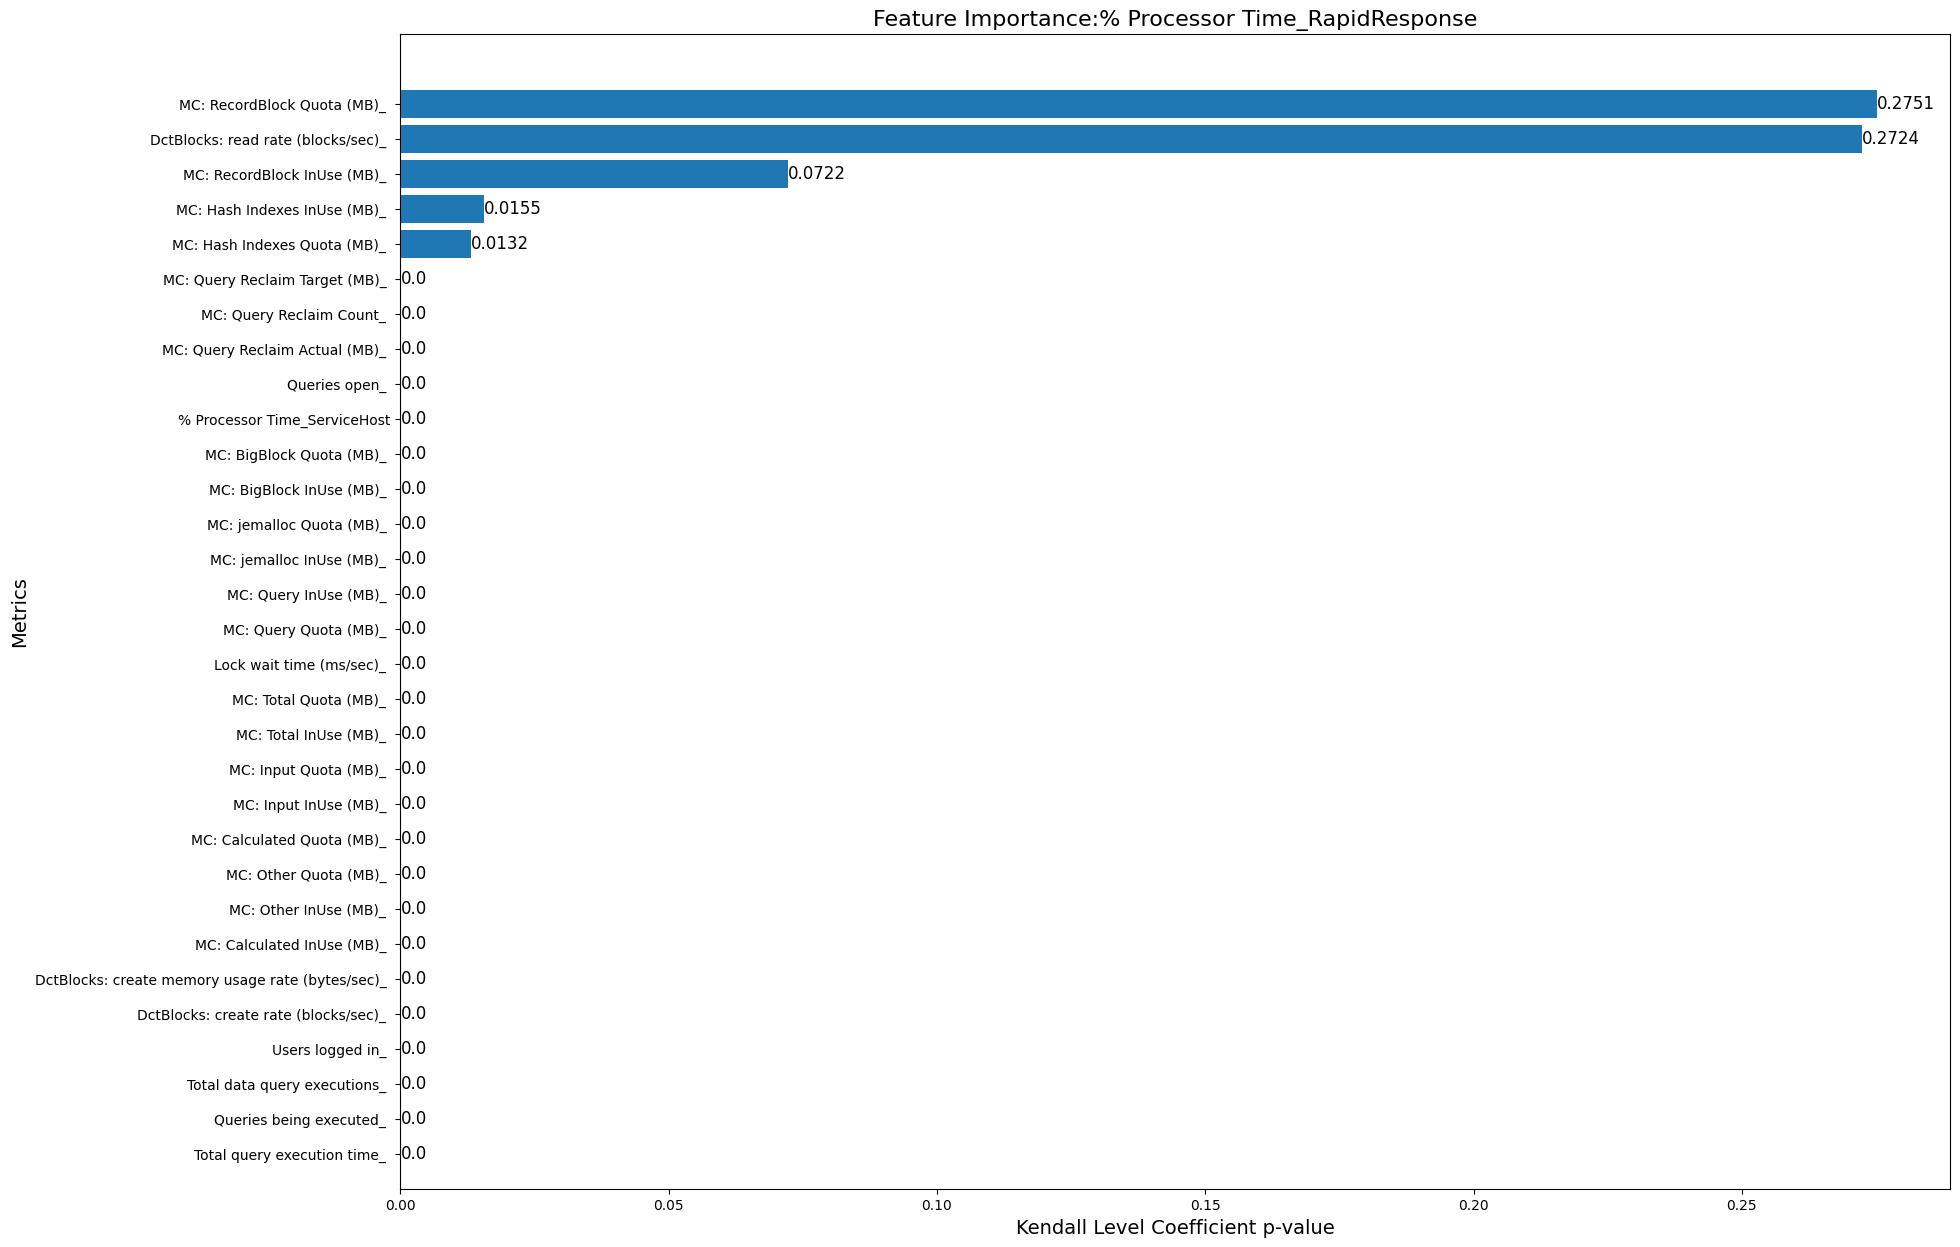

In [12]:
ken_coe_dct = kendall_corr_test(mod_df)


### Causality Inference 

In [13]:
gran_liz,gran_dct = granger_causal_test(mod_df)

The granger causing variables to % Processor Time_RapidResponse are:  Index(['DctBlocks: create memory usage rate (bytes/sec)_ ',
       'DctBlocks: create rate (blocks/sec)_ ', 'Lock wait time (ms/sec)_ ',
       'MC: BigBlock InUse (MB)_ ', 'MC: BigBlock Quota (MB)_ ',
       'Queries being executed_ ', 'Users logged in_ ',
       'MC: Calculated InUse (MB)_ ', 'MC: Other InUse (MB)_ ',
       'MC: Other Quota (MB)_ ', 'MC: Query InUse (MB)_ ',
       'MC: Query Quota (MB)_ ', 'MC: RecordBlock InUse (MB)_ ',
       'MC: Total InUse (MB)_ ', 'MC: Total Quota (MB)_ ',
       'MC: jemalloc InUse (MB)_ ', 'MC: jemalloc Quota (MB)_ ',
       'Queries open_ '],
      dtype='object')


hint: the symbol means the direction of the transfer entropy, the negative means x->y, the positive means y->x
 Computing feature importance...


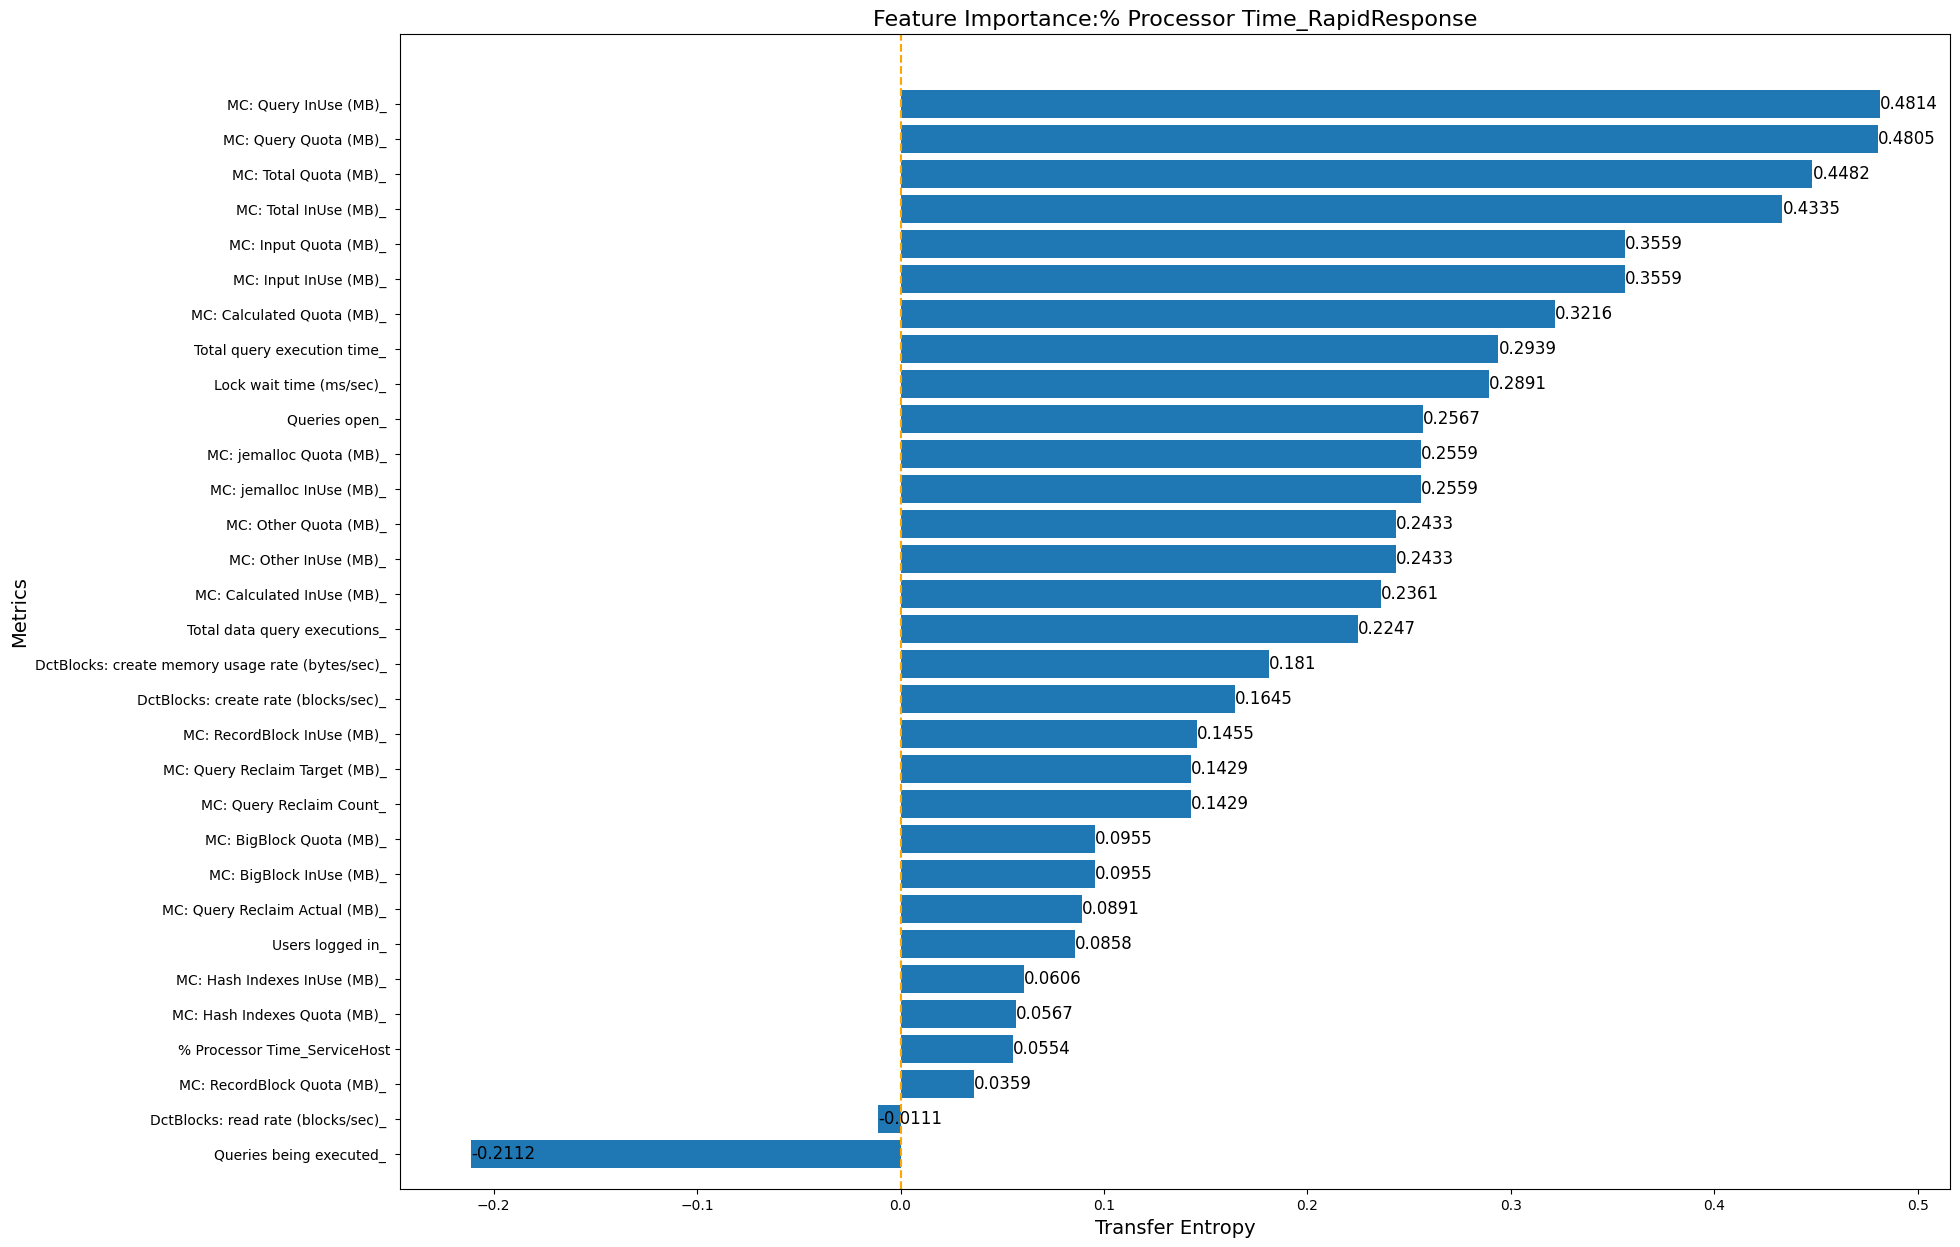

In [14]:
#transfer entropy
trans_en_dct = trans_en_test(mod_df)

## ML: LSTM

2/2 [==============================] - 0s 10ms/step - loss: 0.7517 - mean_absolute_error: 0.5949 - mean_squared_error: 0.7517 - root_mean_squared_error: 0.8594 - mean_absolute_percentage_error: 60394124.0000


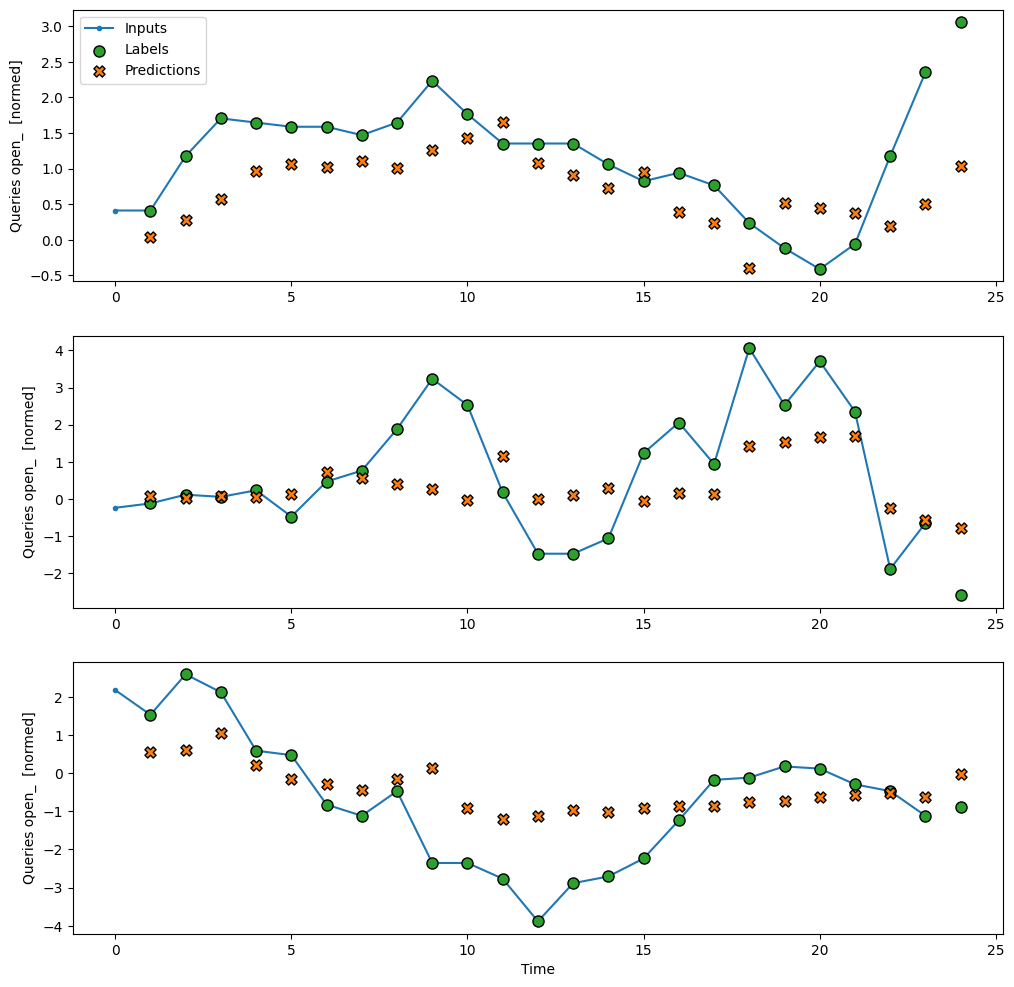

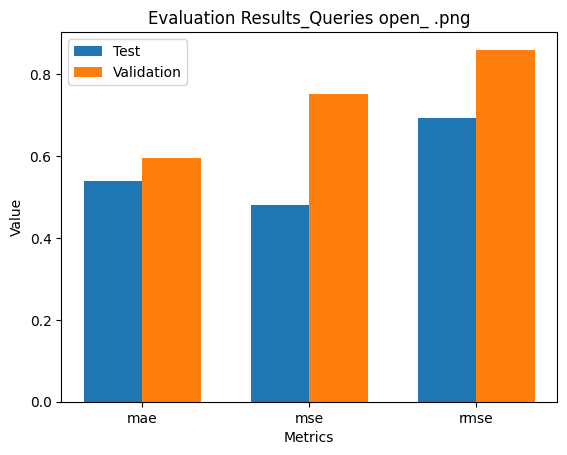

 Computing LSTM feature importance...


100%|██████████| 32/32 [00:02<00:00, 15.10it/s]


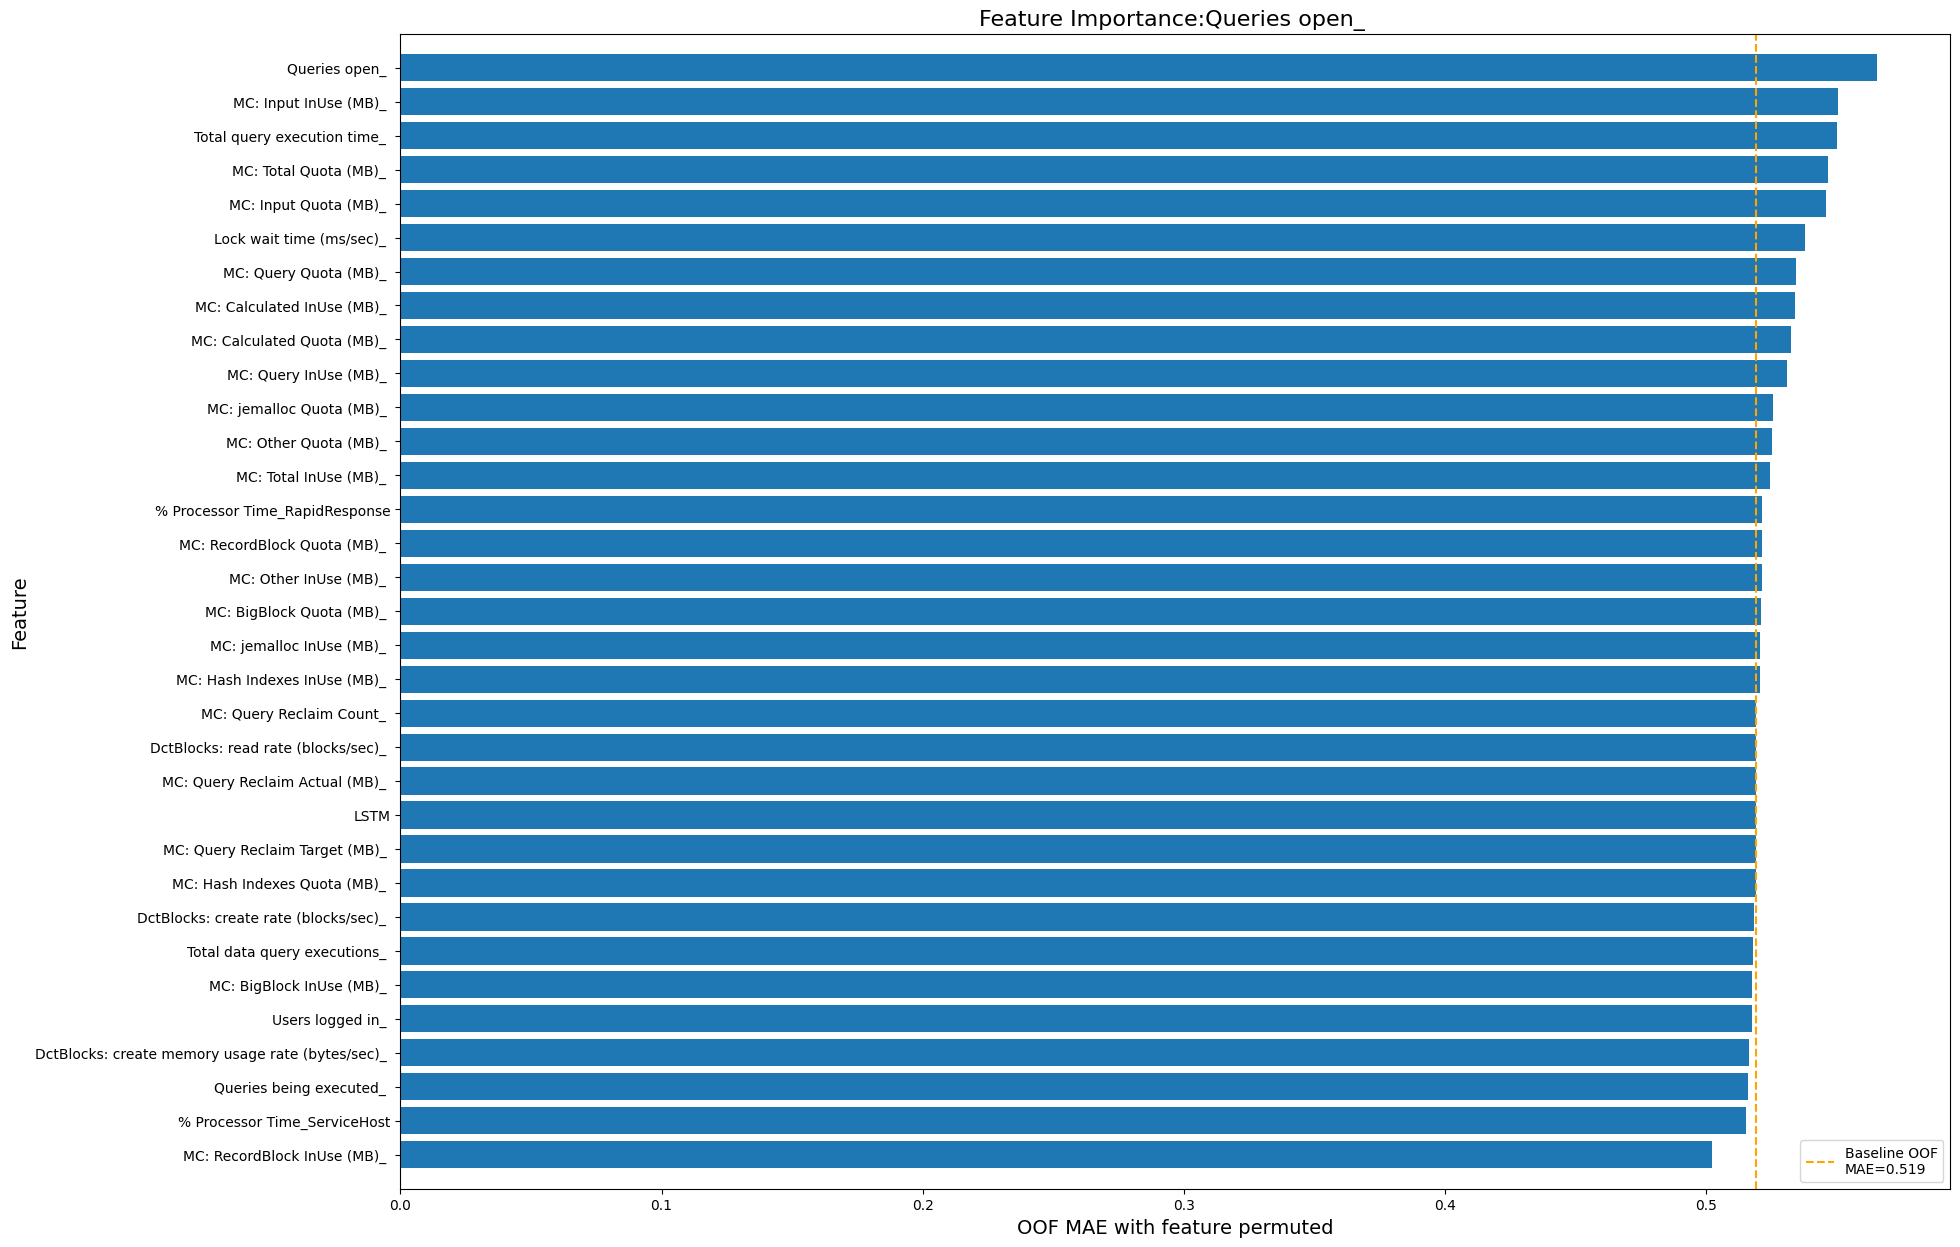

In [15]:
drop_col_list = []
train_df, val_df, test_df = train_test_val_split(mod_df)
train_df, val_df, test_df, mod_df ,variables = preprocess_df(train_df, val_df, test_df, mod_df, drop_col_list)

output_path  = 'C:/WorkNote/Term Conclusion/sp/'
if not os.path.exists(output_path):
    os.makedirs(output_path )

nn_model_vis(variables,train_df, val_df, test_df,output_path)